# Importing Libraries

In [1]:
#pip install nltk
#!pip install scikit-learn
#!pip install lightgbm
#!pip install matplotlib
# import sys
# print(sys.version)

In [89]:
import pandas as pd
import numpy as np
import string as st
from string import punctuation
import re
import nltk
import time
from datetime import datetime
from nltk.corpus import stopwords
from nltk import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import sklearn as sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from itertools import cycle
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import matplotlib as matplotlib 
#import pickle as pickle
#import sqlite3
#import sqlalchemy
import importlib.util as ilu
import sys

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
nltk.download('punkt')
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joseph.rivera_novare\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joseph.rivera_novare\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\joseph.rivera_novare\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joseph.rivera_novare\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def IMP_CHK_FNC(PKG_NME):
    SPC = ilu.find_spec(PKG_NME)
    if SPC is None:
        print(PKG_NME + " is not installed.")
        print(f"Installing {PKG_NME}...")
        !pip3 install PKG_NME
    elif SPC is not None:
        print(PKG_NME + " already installed.")

# Loading the Data

In [6]:
data = pd.read_csv("showroom_data.csv", encoding = 'unicode_escape')
data['narrative'] = data['narative'].astype(str)
#data.columns = [x.lower() for x in data.columns]
data = data[['record_no', 'narrative', 'reason']]
data.head()

,record_no,narrative,reason
0,633805656,PATRON IS A DIAMOND CARDHOLDER WHO BECAME A ME...,BRIBERY AND CORRUPTION OF PUBLIC OFFICERS
1,678106207,CLIENT LEONARDO GREFALDE PAULICAN OPENED AN AC...,BRIBERY AND CORRUPTION OF PUBLIC OFFICERS
2,659345361,"""BETHSHEBA R. BAUTISTA HAS SIGNIFICANT AML-REL...",BRIBERY AND CORRUPTION OF PUBLIC OFFICERS
3,676619114,ON OCTOBER 27 2020 IT WAS PUBLISHED IN THE CNN...,BRIBERY AND CORRUPTION OF PUBLIC OFFICERS
4,717498515,"""REVIEW WAS TRIGGERED BY A NEWS ALERT PUBLISHE...",BRIBERY AND CORRUPTION OF PUBLIC OFFICERS


In [7]:
data['reason'].value_counts()

reason
BRIBERY AND CORRUPTION OF PUBLIC OFFICERS                          10
DRUG TRAFFICKING & RELATED OFFENSES                                10
GRAFT & CORRUPT PRACTICES                                          10
KIDNAPPING FOR RANSOM                                              10
PLUNDER                                                            10
ROBBERY & EXTORTION                                                10
SMUGGLING                                                          10
SWINDLING                                                          10
TERRORISM AND CONSPIRACY TO COMMIT TERRORISM                       10
VIOLATIONS OF THE INTELLECTUAL PROPERTY CODE OF THE PHILIPPINES    10
Name: count, dtype: int64

In [8]:
data['reason'].nunique()

10

# Preprocessing

In [9]:
pre_process_timestamp_start = time.time()

# Remove Punctuations

In [10]:
# Removes  punctuations inside the Narrative Column
def remove_punct(text: str) -> str:
    """
    Remove Punctuations, common preprocessing step that helps simplify text data and improve the accuracy of 
    downstream NLP tasks such as text classification, sentiment analysis, and language modeling.
    """
    
    return re.sub(r"[',.;@#?!&$><%^*+`~()|]+\ *", " ", text)

data["removed_punc"] = data["narrative"].apply(lambda x: remove_punct(x))

# Convert text to tokens

In [11]:
# Coverts the Narrative into token form by spliting using the white space

def tokenize(text: str) -> list[str]:
    """ 
    Convert text to tokens, breaking up text into individual words, phrases, or other meaningful elements, known as tokens. 
    Tokenization is a critical preprocessing step in many NLP tasks, such as text classification, sentiment analysis, and language modeling
    """
    
    text = re.split("\s+", text)
    return [x.lower() for x in text]

data["tokens"] = data["removed_punc"].apply(lambda msg: tokenize(msg))

# Remove Small Tokens

In [12]:
# Remove tokens of length less than 3

def remove_small_words(text) -> list[str]:
    """ 
    Remove Small tokens and Stop Words, removal of tokens with length less equal to or less than 3, 
    and removal of stop words which are common words that don't impact the meaning of the narrative
    """
    
    return [x for x in text if len(x) > 3]

data["larger_tokens"] = data["tokens"].apply(lambda x: remove_small_words(x))

# Remove Stopwords

In [13]:
# Removes stop words using the NLTK stop words library

def remove_stopwords(text: str) -> list[str]:
    """ 
    Remove stopwords. Here, NLTK corpus list is used for a match. However, a customized user-defined 
    list could be created and used to limit the matches in input text. 
    """
    
    return [word for word in text if word not in nltk.corpus.stopwords.words("english")]

data["clean_tokens"] = data["larger_tokens"].apply(lambda x: remove_stopwords(x))

# Stemming

In [14]:
# Apply stemming to get root words

def stemming(text: str) -> list[str]:
    """
    Stemming, process of reducing a word to its root or base form, known as a stem, by removing suffixes or prefixes
    """
    
    ps = PorterStemmer()
    return [ps.stem(word) for word in text]

data["stem_words"] = data["clean_tokens"].apply(lambda wrd: stemming(wrd))

# Lemmatization

In [15]:
# Apply lemmatization on tokens
def lemmatize(text: str) -> list[str]:
    """ 
    Lemmatization, process of reducing a word to its base or dictionary form, known as a lemma, 
    by considering the context and morphological analysis of the word
    """
    
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

data["lemma_words"] = data["clean_tokens"].apply(lambda x: lemmatize(x))

# Token to Sentence

In [16]:
# Create sentences to get clean text as input for vectors


def return_sentences(tokens: str) -> str:
    """Token to Sentences, Return the cleaned text into sentences, 
    this function is done before loading clean text into vectorizer
    
    """
    
    return " ".join([word for word in tokens])

data["clean_text"] = data["lemma_words"].apply(lambda x: return_sentences(x))

# Preprocessing Duration

In [17]:
pre_process_timestamp_end = time.time()
pre_process_duration = pre_process_timestamp_end - pre_process_timestamp_start
print(f"Preprocessing Duration: {pre_process_duration}")

Preprocessing Duration: 14.834524869918823


# Narrative before preprocessing

In [18]:
data['narrative'][0]

'PATRON IS A DIAMOND CARDHOLDER WHO BECAME A MEMBER ON 01/16/2019. HE WAS ARRESTED ON OCTOBER 8 AFTER ALLEGEDLY TRYING TO BRIBE A POLICE OFFICIAL TO NEGOTIATE THE RELEASE OF THEIR FELLOW CHINESE NATIONALS ARRESTED IN A RAID OF A PROSTITUTION DEN. THEY APPROACHED MAJ GEN GIDEON INES JR WHO IS THE CHIEF OF CRIMINAL INVESTIGATION SECTION OF MAKATI OFFICE AND OFFERED PHP 1.7M IN EXCHANGE FOR THEIR RELEASE BUT INES DECLINED AND ORDERED THE ARREST OF FAN AND HIS ASSOCIATE ZHANG XIUQIANG.'

# Narrative after preprocessing

In [19]:
# Display the clean_text of the first sample

data['clean_text'][0]

'patron diamond cardholder became member 01/16/2019 arrested october allegedly trying bribe police official negotiate release fellow chinese national arrested raid prostitution approached gideon ines chief criminal investigation section makati office offered exchange release ines declined ordered arrest associate zhang xiuqiang'

# Preprocessing results

In [20]:
# Create a data frame to store preprocessing results
# Take the lenght of the narrative after every step of preprocessing to display how many characters are reduced
# Display Preprocessing Results

char_count = pd.DataFrame(data=data["narrative"])

char_count["CHAR_COUNT"] = data["narrative"].str.len()
char_count["CLEAN_CHAR_COUNT"] = data["clean_text"].str.len()
char_count["REMOVED_PUNC_COUNT"] = data["removed_punc"].str.len()
char_count["TOKEN"] = data["tokens"].str.len()
char_count["LARGE_TOKEN_COUNT"] = data["larger_tokens"].str.len()
char_count["STEM_WORDS_COUNT"] = data["stem_words"].str.len()
char_count["LEMMA_WORDS_COUNT"] = data["lemma_words"].str.len()
char_count["PERCENT_REMOVED"] = ((data["narrative"].str.len() - data["clean_text"].str.len()) / data["narrative"].str.len())*100

char_count.head()

,narrative,CHAR_COUNT,CLEAN_CHAR_COUNT,REMOVED_PUNC_COUNT,TOKEN,LARGE_TOKEN_COUNT,STEM_WORDS_COUNT,LEMMA_WORDS_COUNT,PERCENT_REMOVED
0,PATRON IS A DIAMOND CARDHOLDER WHO BECAME A ME...,485,328,483,85,44,40,40,32.371134
1,CLIENT LEONARDO GREFALDE PAULICAN OPENED AN AC...,637,430,630,110,55,52,52,32.496075
2,"""BETHSHEBA R. BAUTISTA HAS SIGNIFICANT AML-REL...",2985,1969,2966,502,269,242,242,34.036851
3,ON OCTOBER 27 2020 IT WAS PUBLISHED IN THE CNN...,751,515,744,125,70,64,64,31.424767
4,"""REVIEW WAS TRIGGERED BY A NEWS ALERT PUBLISHE...",1894,1354,1861,292,179,163,163,28.511088


# Train-Test Split

In [21]:
# Set X as the clean_text values, Independent Variabe.
# Set y as the reason values, Dependent Variable.
# Set z as record_no, used for referencing after the split.

X = data["clean_text"].values
y = data["reason"].values
z = data['record_no'].values

In [22]:
#Run the train_test_split function to ceate 80/20 split of the data.

# X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.3, random_state=0)

In [23]:
# Display both the predicate crimes, and how many samples each inside the training set

# np.unique(X_train, return_counts=True)
# np.unique(y_train, return_counts=True)

# Vectorization Using TF-IDF

In [24]:
# Create a Vectorizer Variable named tfidf using TfidfVctorizer().
# Train the Vectorizer using X_train (training data).
# Pattern is a preventive step to ensure that no tokens less than 3 in length, or numeric, are present in the text corpus.
# Display the lenght of the vocabulary (how many words the corpus have).

tfidf = TfidfVectorizer(token_pattern = r'\b[a-zA-Z]{4,}\b')
#tfidf = tfidf.fit(X)

X_tfidf = tfidf.fit_transform(X)
#X_test_tfidf = tfidf.transform(X_test)

In [25]:
len(tfidf.vocabulary_)

2698

In [26]:
# Print out how many keys/words have less than 3 in length
# Check if key/word is less than 4 in length and or numeric
# Will not print anything if sucessfully removed

for key, value in tfidf.vocabulary_.items():
    if len(key) < 3:
        print(key)
    elif key.isdigit() :
        print(key)

In [27]:
# Search if a word exists in the tfidf vocabulary, will display the index if exists.

word_to_search = "the"
if word_to_search in tfidf.vocabulary_:
    print(f'The word "{word_to_search}" is present in the vocabulary with index {tfidf.vocabulary_[word_to_search]}.')
else:
    print(f'The word "{word_to_search}" is not present in the vocabulary.')

The word "the" is not present in the vocabulary.


In [28]:
# Transform X_train to vectorized form
#Transform X_test to vectorized form

#X_train_trans = tfidf.transform(X_train)#.toarray()
#X_test_trans = tfidf.transform(X_test)#.toarray()

In [29]:
# pca = PCA(n_components=500)
# pca.fit(X_train_tfidf.toarray())

In [30]:
# X_train_pca = pca.transform(X_train_tfidf.toarray())
# X_test_pca = pca.transform(X_test_tfidf.toarray())

# Truncated SVD

In [31]:
svd = TruncatedSVD(n_components=120, random_state=0)

In [32]:
#They are already in dense form, there is no need to convert them to sparse format using .toarray()

X_svd = svd.fit_transform(X_tfidf)
#X_test_svd = svd.transform(X_test_tfidf)

# Export Model

In [33]:
# Export tfidf model

#pickle.dump(tfidf, open("tfidf.pkl", "wb"))

In [34]:
# Export scv model

#pickle.dump(svd, open("svd.pkl", "wb"))

# Machine Learning Models

## LGBoost

In [35]:
# Build Naive Bayes Model

lgb = LGBMClassifier()
lgb

LGBMClassifier()

In [36]:
# Display Naive Bayes Parameters

lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [37]:
# Create a dictionary of parameters to be tested

lgb_parameters = {
    'learning_rate': [0.1, 0.01, 0.05, 0.001],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200, 300],
    'feature_fraction': [0.3, 0.6, 0.9]
}

In [38]:
# Load the parameters into the GridSearchCV
# Train the Grid Model

lgb_grid = GridSearchCV(estimator=lgb,
                        param_grid=lgb_parameters,
                        scoring='accuracy',
                        cv=2,
                        n_jobs=-1)

lgb_grid.fit(X_svd, y)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3467
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 100
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training

GridSearchCV(cv=2, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'feature_fraction': [0.3, 0.6, 0.9],
                         'learning_rate': [0.1, 0.01, 0.05, 0.001],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='accuracy')

In [39]:
# Display which combination of parameters generated the highest accuracy

best_accuracy = lgb_grid.best_score_
best_parameters = lgb_grid.best_params_

print("Best Accuracy (LightGBM): {:.2f} %".format(best_accuracy*100))
print("Best Parameters (LightGBM): ", best_parameters)

Best Accuracy (LightGBM): 58.00 %
Best Parameters (LightGBM):  {'feature_fraction': 0.3, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


In [40]:
# Load the best parameters into the model

lgb.set_params(**lgb_grid.best_params_)

LGBMClassifier(feature_fraction=0.3, learning_rate=0.01, max_depth=3,
               n_estimators=300)

In [41]:
# Train the model using best parameters
# Start Model Training Time

lgb_training_start = time.time()
lgb.fit(X_svd, y)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3467
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 100
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(feature_fraction=0.3, learning_rate=0.01, max_depth=3,
               n_estimators=300)

In [42]:
# y_lgb_proba = lgb.predict(X_svd, num_iteration=lgb.best_iteration)
# y_lgb_proba = lgb.predict(X_svd, num_iteration=lgb.best_iteration)

In [43]:
# Ends Model Training time
# Computes Model Training Duration
# Display Model Training Time

lgb_training_stop = time.time()
lgb_training_duration = lgb_training_stop - lgb_training_start
print(f"LightGBM training time: {lgb_training_duration}s")

LightGBM training time: 1.00099778175354s


# Support Vector Machines (SVM)

In [44]:
# Build Support vector Machine Model

svm = SVC(kernel = 'linear', random_state = 0, probability = True)
svm

SVC(kernel='linear', probability=True, random_state=0)

In [45]:
# Display Support vector Machine Parameters

svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [46]:
# Create a dictionary of parameters to be tested

svm_parameters = {
    'C': [0.1, 1.0],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

In [47]:
# Load the parameters into the GridSearchCV
# Train the Grid Model

svm_grid = GridSearchCV(estimator = svm,
                         param_grid = svm_parameters,
                         scoring = 'accuracy',
                         cv = 2,
                         n_jobs = -1)

svm_grid.fit(X_svd, y)

GridSearchCV(cv=2,
             estimator=SVC(kernel='linear', probability=True, random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.1, 1.0], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [48]:
# Display which combination of parameters generated the highest accuracy

best_accuracy = svm_grid.best_score_
best_parameters = svm_grid.best_params_

print("Best Accuracy (SVM): {:.2f} %".format(best_accuracy*100))
print("Best Parameters (SVM): ", best_parameters)

Best Accuracy (SVM): 68.00 %
Best Parameters (SVM):  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [49]:
# Load the best parameters into the model

svm.set_params(**svm_grid.best_params_)

SVC(C=0.1, kernel='linear', probability=True, random_state=0)

In [50]:
# Start Model Training Time
# Train the model using best parameters

svm_training_start = time.time()
svm.fit(X_svd, y)

SVC(C=0.1, kernel='linear', probability=True, random_state=0)

In [51]:
# Ends Model Training time
# Computes Model Training Duration
# Display Model Training Time

svm_training_stop = time.time()
svm_training_duration = svm_training_stop - svm_training_start
print(f"SVM training time: {svm_training_duration}s")

SVM training time: 0.05107283592224121s


# Random Forest

In [52]:
#Build Random Forest model

rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf

RandomForestClassifier(random_state=0)

In [53]:
# Display Random Forest Parameters

rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [54]:
# Create a dictionary of parameters to be tested

rf_parameters = {
    'n_estimators': [10, 50, 100],  # number of trees in the forest
    'max_depth': [None, 10, 20],  # maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # minimum number of samples required to be at a leaf node
}

In [55]:
# Load the parameters into the GridSearchCV
# Train the Grid Model

rf_grid = GridSearchCV(estimator = rf,
                         param_grid = rf_parameters,
                         scoring = 'accuracy',
                         cv = 2, #add this for proper training
                         n_jobs = -1)
rf_grid.fit(X_svd, y)

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring='accuracy')

In [56]:
# Display which combination of parameters generated the highest accuracy

best_accuracy = rf_grid.best_score_
best_parameters = rf_grid.best_params_

print("Best Accuracy (RF): {:.2f} %".format(best_accuracy*100))
print("Best Parameters (RF): ", best_parameters)

Best Accuracy (RF): 66.00 %
Best Parameters (RF):  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [57]:
# Load the best parameters into the model

rf.set_params(**rf_grid.best_params_)

RandomForestClassifier(min_samples_split=10, random_state=0)

In [58]:
# Start Model Training Time
# Train the model using best parameters

rf_training_start = time.time()
rf.fit(X_svd, y)

RandomForestClassifier(min_samples_split=10, random_state=0)

In [59]:
# Ends Model Training time
# Computes Model Training Duration
# Display Model Training Time

rf_training_stop = time.time()
rf_training_duration = rf_training_stop - rf_training_start
print(f"Random Forest training time: {rf_training_duration}s")

Random Forest training time: 0.48522400856018066s


# Voting Classifier

In [60]:
# Build Voting Classifier
# Set the 3 trained models inside the Voting Classifier
# Set voting to Soft -> takes the average predicted probability of the 3 models

vc = VotingClassifier([('clf1', lgb), ('clf2', svm), ('clf3', rf)], voting = 'soft')

In [61]:
# Create a dictionary of model weights to be tested

vc_parameters = {
    'weights': [[1,1,1], [2,1,1], [1,2,1], [1,1,2]],
}

In [62]:
# Load the dictionary into the GridSearchCV
# Train the Grid Model

vc_grid = GridSearchCV(estimator = vc,
                         param_grid = vc_parameters,
                         scoring = 'accuracy',
                         cv = 2,
                         n_jobs = -1)

vc_grid.fit(X_svd, y)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3467
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 100
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training

GridSearchCV(cv=2,
             estimator=VotingClassifier(estimators=[('clf1',
                                                     LGBMClassifier(feature_fraction=0.3,
                                                                    learning_rate=0.01,
                                                                    max_depth=3,
                                                                    n_estimators=300)),
                                                    ('clf2',
                                                     SVC(C=0.1, kernel='linear',
                                                         probability=True,
                                                         random_state=0)),
                                                    ('clf3',
                                                     RandomForestClassifier(min_samples_split=10,
                                                                            random_state=0))],
                                        voting='soft'),
             n_jobs=-1,
             param_grid={'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1],
                                     [1, 1, 2]]},
             scoring='accuracy')

In [63]:
# Display which combination of parameters generated the highest accuracy

best_accuracy = vc_grid.best_score_
best_parameters = vc_grid.best_params_

print("Best Accuracy (Voting Classifier): {:.2f} %".format(best_accuracy*100))
print("Best Parameters (Voting Classifier): ", best_parameters)

Best Accuracy (Voting Classifier): 63.00 %
Best Parameters (Voting Classifier):  {'weights': [1, 1, 2]}


In [64]:
# Load the best parameters into the model
vc.set_params(**vc_grid.best_params_)

VotingClassifier(estimators=[('clf1',
                              LGBMClassifier(feature_fraction=0.3,
                                             learning_rate=0.01, max_depth=3,
                                             n_estimators=300)),
                             ('clf2',
                              SVC(C=0.1, kernel='linear', probability=True,
                                  random_state=0)),
                             ('clf3',
                              RandomForestClassifier(min_samples_split=10,
                                                     random_state=0))],
                 voting='soft', weights=[1, 1, 2])

In [65]:
# Start Model Training Time
# Train the model using best parameters

vc_training_start = time.time()
vc.fit(X_svd, y)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3467
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 100
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

VotingClassifier(estimators=[('clf1',
                              LGBMClassifier(feature_fraction=0.3,
                                             learning_rate=0.01, max_depth=3,
                                             n_estimators=300)),
                             ('clf2',
                              SVC(C=0.1, kernel='linear', probability=True,
                                  random_state=0)),
                             ('clf3',
                              RandomForestClassifier(min_samples_split=10,
                                                     random_state=0))],
                 voting='soft', weights=[1, 1, 2])

In [66]:
# Ends Model Training time
# Computes Model Training Duration
# Display Model Training Time

vc_training_stop = time.time()
vc_training_duration = vc_training_stop - vc_training_start
print(f"Voting Classifer training time: {vc_training_duration}s")

Voting Classifer training time: 1.5353126525878906s


# Export the Models

In [67]:
# Export LightGBM model

#pickle.dump(lgb, open("lgb.pkl", "wb"))

In [68]:
# Export Support Vector Machine model

#pickle.dump(svm, open('svm.pkl', 'wb'))

In [69]:
# Export Random Forest model

#pickle.dump(rf, open('rf.pkl', 'wb'))

In [70]:
# Export KNN t model

#pickle.dump(rf, open('knn.pkl', 'wb'))

In [71]:
# Export Voting Classifier model

#pickle.dump(vc, open('votingclass.pkl', 'wb'))

# Training Performance

### LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3467
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 100
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

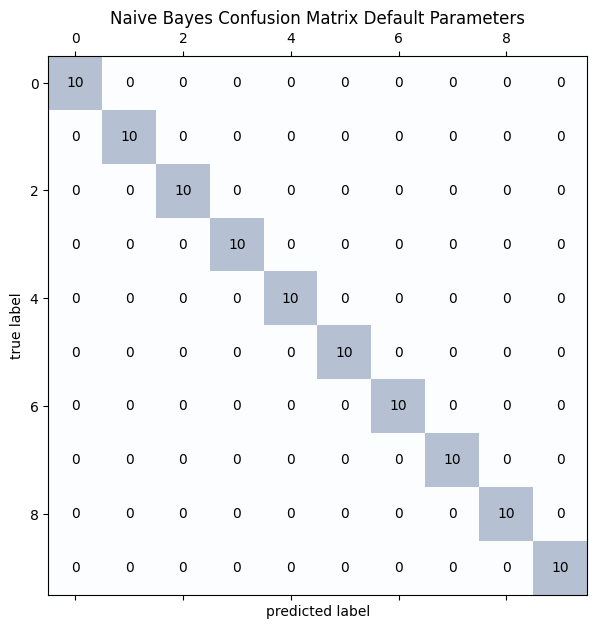



                                                                 precision    recall  f1-score   support

                      BRIBERY AND CORRUPTION OF PUBLIC OFFICERS       1.00      1.00      1.00        10
                            DRUG TRAFFICKING & RELATED OFFENSES       1.00      1.00      1.00        10
                                      GRAFT & CORRUPT PRACTICES       1.00      1.00      1.00        10
                                          KIDNAPPING FOR RANSOM       1.00      1.00      1.00        10
                                                        PLUNDER       1.00      1.00      1.00        10
                                            ROBBERY & EXTORTION       1.00      1.00      1.00        10
                                                      SMUGGLING       1.00      1.00      1.00        10
                                                      SWINDLING       1.00      1.00      1.00        10
                   TERRORISM AND CONSPIRACY TO COMMI

In [72]:
# Displays Confusion Matrix and Classification Report Score (Default Parameters)

lgb_def = LGBMClassifier()
lgb_def.fit(X_svd, y)

y_pred_lgb_train = lgb_def.predict(X_svd)
confmat = confusion_matrix(y_true=y, y_pred=y_pred_lgb_train)

fig, ax = plt.subplots(figsize=(13, 7))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
        
plt.title("Naive Bayes Confusion Matrix Default Parameters")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()
print("\n")
print(classification_report(y, y_pred_lgb_train))

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3


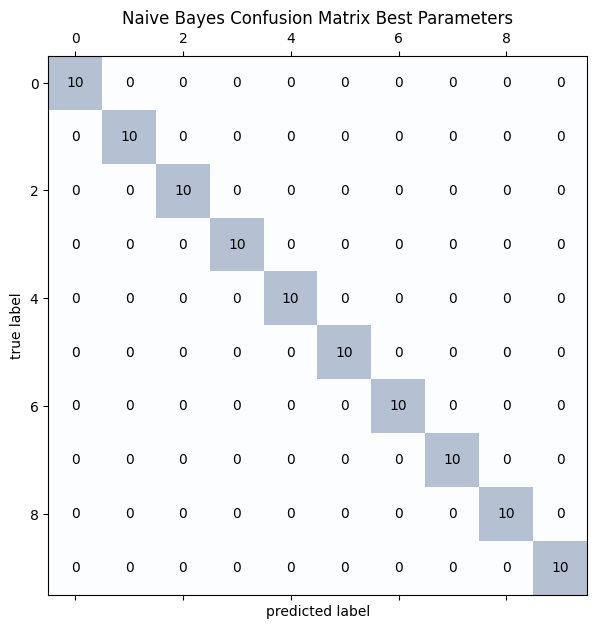



                                                                 precision    recall  f1-score   support

                      BRIBERY AND CORRUPTION OF PUBLIC OFFICERS       1.00      1.00      1.00        10
                            DRUG TRAFFICKING & RELATED OFFENSES       1.00      1.00      1.00        10
                                      GRAFT & CORRUPT PRACTICES       1.00      1.00      1.00        10
                                          KIDNAPPING FOR RANSOM       1.00      1.00      1.00        10
                                                        PLUNDER       1.00      1.00      1.00        10
                                            ROBBERY & EXTORTION       1.00      1.00      1.00        10
                                                      SMUGGLING       1.00      1.00      1.00        10
                                                      SWINDLING       1.00      1.00      1.00        10
                   TERRORISM AND CONSPIRACY TO COMMI

In [73]:
# Displays Confusion Matrix and Classification Report Score (Best Parameters)

y_pred_lgb_train = lgb.predict(X_svd)
confmat = confusion_matrix(y_true=y, y_pred=y_pred_lgb_train)

fig, ax = plt.subplots(figsize=(13, 7))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
        
plt.title("Naive Bayes Confusion Matrix Best Parameters")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()
print("\n")
print(classification_report(y, y_pred_lgb_train))

### Support Vector Machines (SVM)

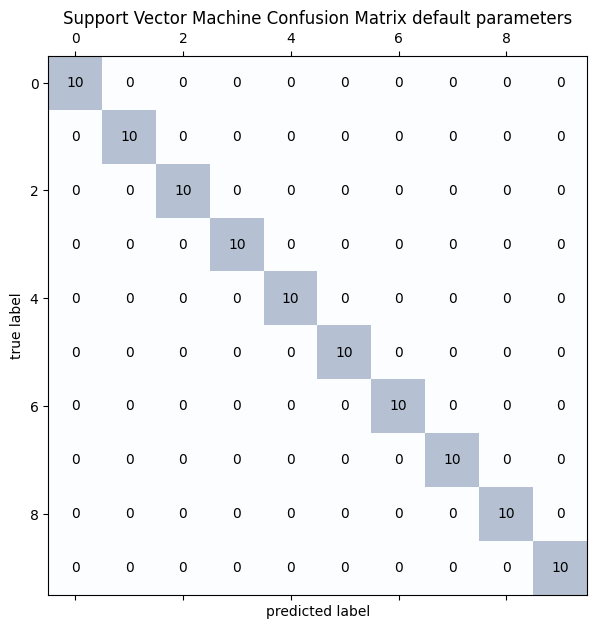



                                                                 precision    recall  f1-score   support

                      BRIBERY AND CORRUPTION OF PUBLIC OFFICERS       1.00      1.00      1.00        10
                            DRUG TRAFFICKING & RELATED OFFENSES       1.00      1.00      1.00        10
                                      GRAFT & CORRUPT PRACTICES       1.00      1.00      1.00        10
                                          KIDNAPPING FOR RANSOM       1.00      1.00      1.00        10
                                                        PLUNDER       1.00      1.00      1.00        10
                                            ROBBERY & EXTORTION       1.00      1.00      1.00        10
                                                      SMUGGLING       1.00      1.00      1.00        10
                                                      SWINDLING       1.00      1.00      1.00        10
                   TERRORISM AND CONSPIRACY TO COMMI

In [74]:
# Displays Confusion Matrix and Classification Report Score (Default Parameters)

svm_def = SVC(kernel = 'linear', random_state = 0, probability = True)
svm_def.fit(X_svd, y)

y_pred_svm_train = svm_def.predict(X_svd)
confmat = confusion_matrix(y_true=y, y_pred=y_pred_svm_train)

fig, ax = plt.subplots(figsize=(13, 7))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
        
plt.title("Support Vector Machine Confusion Matrix default parameters")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()
print("\n")
print(classification_report(y, y_pred_svm_train))

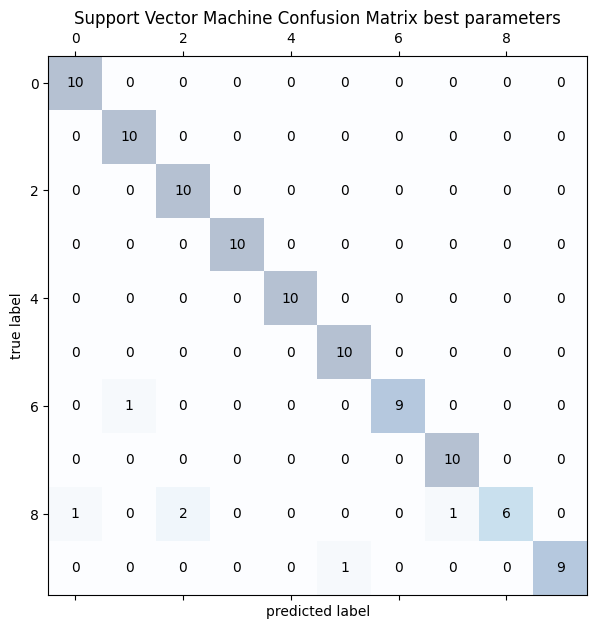



                                                                 precision    recall  f1-score   support

                      BRIBERY AND CORRUPTION OF PUBLIC OFFICERS       0.91      1.00      0.95        10
                            DRUG TRAFFICKING & RELATED OFFENSES       0.91      1.00      0.95        10
                                      GRAFT & CORRUPT PRACTICES       0.83      1.00      0.91        10
                                          KIDNAPPING FOR RANSOM       1.00      1.00      1.00        10
                                                        PLUNDER       1.00      1.00      1.00        10
                                            ROBBERY & EXTORTION       0.91      1.00      0.95        10
                                                      SMUGGLING       1.00      0.90      0.95        10
                                                      SWINDLING       0.91      1.00      0.95        10
                   TERRORISM AND CONSPIRACY TO COMMI

In [75]:
# Displays Confusion Matrix and Classification Report Score

y_pred_svm_train = svm.predict(X_svd)
confmat = confusion_matrix(y_true=y, y_pred=y_pred_svm_train)

fig, ax = plt.subplots(figsize=(13, 7))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
        
plt.title("Support Vector Machine Confusion Matrix best parameters")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()
print("\n")
print(classification_report(y, y_pred_svm_train))

### Random Forest

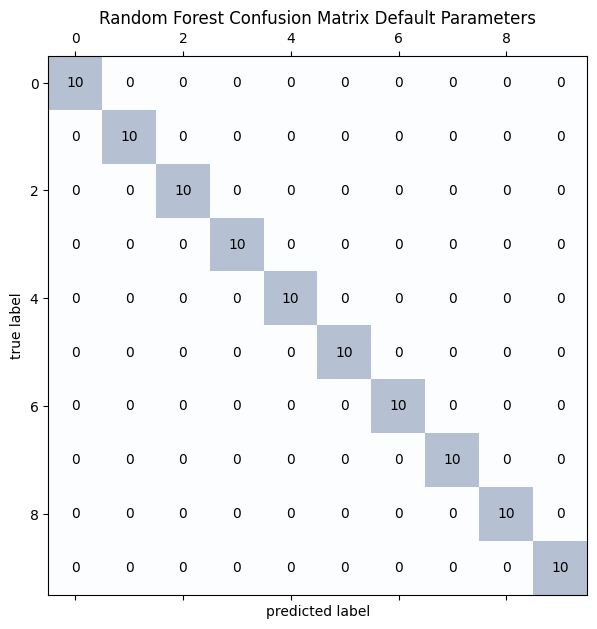



                                                                 precision    recall  f1-score   support

                      BRIBERY AND CORRUPTION OF PUBLIC OFFICERS       1.00      1.00      1.00        10
                            DRUG TRAFFICKING & RELATED OFFENSES       1.00      1.00      1.00        10
                                      GRAFT & CORRUPT PRACTICES       1.00      1.00      1.00        10
                                          KIDNAPPING FOR RANSOM       1.00      1.00      1.00        10
                                                        PLUNDER       1.00      1.00      1.00        10
                                            ROBBERY & EXTORTION       1.00      1.00      1.00        10
                                                      SMUGGLING       1.00      1.00      1.00        10
                                                      SWINDLING       1.00      1.00      1.00        10
                   TERRORISM AND CONSPIRACY TO COMMI

In [76]:
# Displays Confusion Matrix and Classification Report Score (Default Parameters)

rf_def = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_def.fit(X_svd, y)

y_pred_rf_train = rf_def.predict(X_svd)
confmat = confusion_matrix(y_true=y, y_pred=y_pred_rf_train)

fig, ax = plt.subplots(figsize=(13, 7))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
        
plt.title("Random Forest Confusion Matrix Default Parameters")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()
print("\n")
print(classification_report(y, y_pred_rf_train))

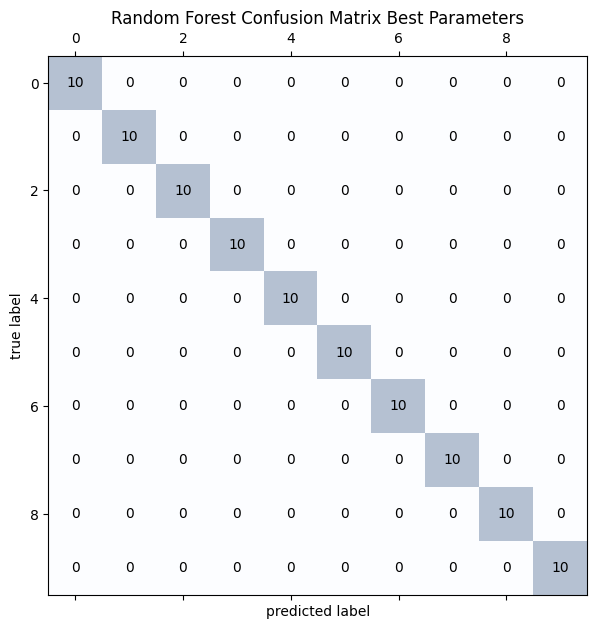



                                                                 precision    recall  f1-score   support

                      BRIBERY AND CORRUPTION OF PUBLIC OFFICERS       1.00      1.00      1.00        10
                            DRUG TRAFFICKING & RELATED OFFENSES       1.00      1.00      1.00        10
                                      GRAFT & CORRUPT PRACTICES       1.00      1.00      1.00        10
                                          KIDNAPPING FOR RANSOM       1.00      1.00      1.00        10
                                                        PLUNDER       1.00      1.00      1.00        10
                                            ROBBERY & EXTORTION       1.00      1.00      1.00        10
                                                      SMUGGLING       1.00      1.00      1.00        10
                                                      SWINDLING       1.00      1.00      1.00        10
                   TERRORISM AND CONSPIRACY TO COMMI

In [77]:
# Displays Confusion Matrix and Classification Report Score (Best Parameters)

y_pred_rf_train = rf.predict(X_svd)
confmat = confusion_matrix(y_true=y, y_pred=y_pred_rf_train)

fig, ax = plt.subplots(figsize=(13, 7))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
        
plt.title("Random Forest Confusion Matrix Best Parameters")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()
print("\n")
print(classification_report(y, y_pred_rf_train))

### Voting Classifier

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3467
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 100
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

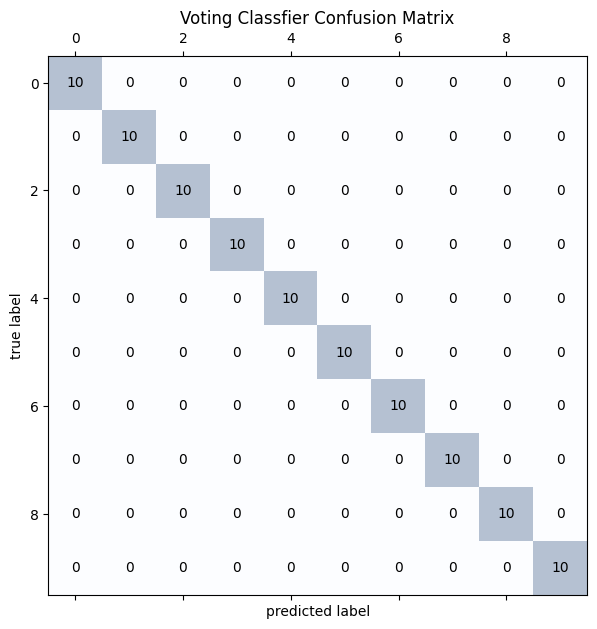



                                                                 precision    recall  f1-score   support

                      BRIBERY AND CORRUPTION OF PUBLIC OFFICERS       1.00      1.00      1.00        10
                            DRUG TRAFFICKING & RELATED OFFENSES       1.00      1.00      1.00        10
                                      GRAFT & CORRUPT PRACTICES       1.00      1.00      1.00        10
                                          KIDNAPPING FOR RANSOM       1.00      1.00      1.00        10
                                                        PLUNDER       1.00      1.00      1.00        10
                                            ROBBERY & EXTORTION       1.00      1.00      1.00        10
                                                      SMUGGLING       1.00      1.00      1.00        10
                                                      SWINDLING       1.00      1.00      1.00        10
                   TERRORISM AND CONSPIRACY TO COMMI

In [78]:
# Displays Confusion Matrix and Classification Report Score Default Weights

vc_def = VotingClassifier([('clf1', lgb_def), ('clf2', svm_def), ('clf3', rf_def)], voting = 'soft')
vc_def.fit(X_svd, y)

y_pred_vc_train = vc_def.predict(X_svd)
confmat = confusion_matrix(y_true=y, y_pred=y_pred_vc_train)

fig, ax = plt.subplots(figsize=(13, 7))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
        
plt.title("Voting Classfier Confusion Matrix")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

print("\n")
print(classification_report(y, y_pred_vc_train))

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3467
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 100
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training

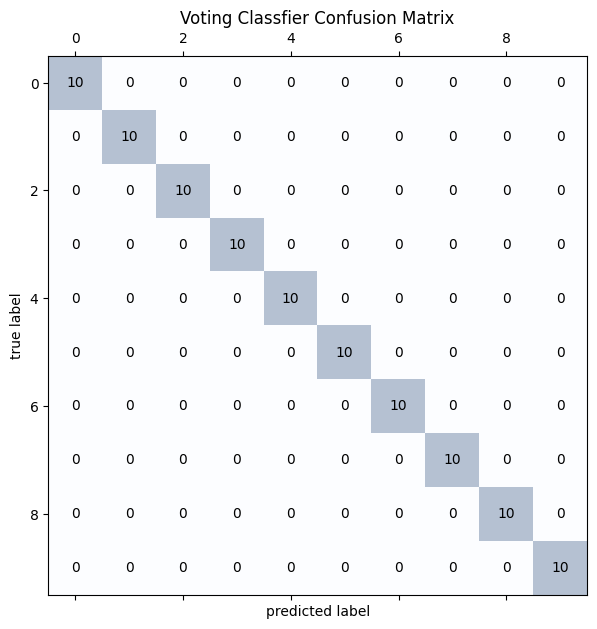



                                                                 precision    recall  f1-score   support

                      BRIBERY AND CORRUPTION OF PUBLIC OFFICERS       1.00      1.00      1.00        10
                            DRUG TRAFFICKING & RELATED OFFENSES       1.00      1.00      1.00        10
                                      GRAFT & CORRUPT PRACTICES       1.00      1.00      1.00        10
                                          KIDNAPPING FOR RANSOM       1.00      1.00      1.00        10
                                                        PLUNDER       1.00      1.00      1.00        10
                                            ROBBERY & EXTORTION       1.00      1.00      1.00        10
                                                      SMUGGLING       1.00      1.00      1.00        10
                                                      SWINDLING       1.00      1.00      1.00        10
                   TERRORISM AND CONSPIRACY TO COMMI

In [79]:
# Displays Confusion Matrix and Classification Report Score Best Weights

vc = VotingClassifier([('clf1', lgb), ('clf2', svm), ('clf3', rf)], voting = 'soft')
vc.fit(X_svd, y)

y_pred_vc_train = vc.predict(X_svd)
confmat = confusion_matrix(y_true=y, y_pred=y_pred_vc_train)

fig, ax = plt.subplots(figsize=(13, 7))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
        
plt.title("Voting Classfier Confusion Matrix")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

print("\n")
print(classification_report(y, y_pred_vc_train))

ROC AUC for class 0: 0.39
ROC AUC for class 1: 0.84
ROC AUC for class 2: 0.41
ROC AUC for class 3: 0.17
ROC AUC for class 4: 0.64
ROC AUC for class 5: 0.68
ROC AUC for class 6: 0.62
ROC AUC for class 7: 0.78
ROC AUC for class 8: 0.45
ROC AUC for class 9: 0.40




['BRIBERY AND CORRUPTION OF PUBLIC OFFICERS'
 'DRUG TRAFFICKING & RELATED OFFENSES' 'GRAFT & CORRUPT PRACTICES'
 'KIDNAPPING FOR RANSOM' 'PLUNDER' 'ROBBERY & EXTORTION' 'SMUGGLING'
 'SWINDLING' 'TERRORISM AND CONSPIRACY TO COMMIT TERRORISM'
 'VIOLATIONS OF THE INTELLECTUAL PROPERTY CODE OF THE PHILIPPINES']






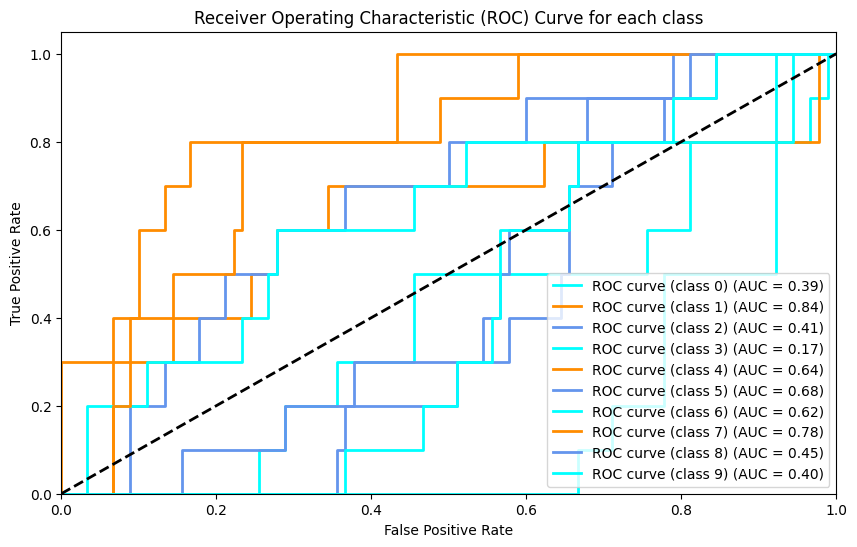

In [80]:
# Number of classes
n_classes = len(np.unique(y))

# Binarize the labels using one-vs-all encoding
y_bin = label_binarize(y, classes=np.unique(y))

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curves and AUC for each class using OvA encoding
for i in range(n_classes):
    # Calculate FPR, TPR, and AUC for class i
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], X_svd[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Print AUC for each class
    print(f"ROC AUC for class {i}: {roc_auc[i]:.2f}")
    
print('\n')
print('================================')
print('\n')
print(np.unique(y))
print('\n')
print('================================')
print('\n')
plt.figure(figsize=(10, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
plt.legend(loc="lower right")
plt.show()

# Final DataFrame

In [81]:
model = vc
X_tfidf = tfidf.fit_transform(X)
X_svd = svd.fit_transform(X_tfidf)
pred_prob = model.predict_proba((X_svd))
df = pd.DataFrame(pred_prob, columns=model.classes_)
output = []
for x in range(len(df)):
    top_three = np.concatenate(
    ((df.iloc[x].nlargest(3).index), (df.iloc[x].nlargest(3).values)),
    axis=None,
    )
    output.append(top_three) 
col_names = [
    "crime_name_1",
    "crime_name_2",
    "crime_name_3",
    "crime_probability_1",
    "crime_probability_2",
    "crime_probability_3",
]
final_output = pd.DataFrame(output, columns=col_names)
final_output["record_no"] = data['record_no']

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3


In [82]:
final_output.head()

,crime_name_1,crime_name_2,crime_name_3,crime_probability_1,crime_probability_2,crime_probability_3,record_no
0,BRIBERY AND CORRUPTION OF PUBLIC OFFICERS,KIDNAPPING FOR RANSOM,DRUG TRAFFICKING & RELATED OFFENSES,0.444022,0.097454,0.073924,633805656
1,BRIBERY AND CORRUPTION OF PUBLIC OFFICERS,GRAFT & CORRUPT PRACTICES,SMUGGLING,0.446794,0.100020,0.082702,678106207
2,BRIBERY AND CORRUPTION OF PUBLIC OFFICERS,ROBBERY & EXTORTION,PLUNDER,0.462545,0.125209,0.062737,659345361
3,BRIBERY AND CORRUPTION OF PUBLIC OFFICERS,GRAFT & CORRUPT PRACTICES,TERRORISM AND CONSPIRACY TO COMMIT TERRORISM,0.486590,0.071562,0.063007,676619114
4,BRIBERY AND CORRUPTION OF PUBLIC OFFICERS,SMUGGLING,PLUNDER,0.403731,0.100753,0.086415,717498515


In [83]:
np.__version__

'1.26.2'

In [86]:
lgb.__version__

AttributeError: 'LGBMClassifier' object has no attribute '__version__'

In [90]:
import lightgbm as lgb
print(lgb.__version__)


4.1.0
